<a href="https://colab.research.google.com/github/orangNLP/NLP_practice-PUB-/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **□데이터 다운 및 캐글 연동**

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"orangkim","key":"83a095e75a3ad155f345dcb4416820d1"}'}

In [ ]:
# json 파일 ~/.kaggle로 이동시키기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c word2vec-nlp-tutorial

 75% 39.0M/51.7M [00:00<00:00, 138MB/s] 
100% 51.7M/51.7M [00:00<00:00, 89.1MB/s]


In [ ]:
from ast import increment_lineno
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from bs4 import BeautifulSoup
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
os.listdir()

['.config', 'word2vec-nlp-tutorial.zip', 'kaggle.json', 'sample_data']

In [ ]:
os.mkdir('./data_in')

In [ ]:
!unzip word2vec-nlp-tutorial.zip

Archive:  word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  


In [ ]:
!unzip labeledTrainData.tsv.zip
!unzip unlabeledTrainData.tsv.zip
!unzip testData.tsv.zip

Archive:  labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    
Archive:  unlabeledTrainData.tsv.zip
  inflating: unlabeledTrainData.tsv  
Archive:  testData.tsv.zip
  inflating: testData.tsv            


In [ ]:
import shutil
shutil.move('/content/labeledTrainData.tsv','/content/data_in/labeledTrainData.tsv')
shutil.move('/content/sampleSubmission.csv','/content/data_in/sampleSubmission.csv')
shutil.move('/content/testData.tsv','/content/data_in/testData.tsv')
shutil.move('/content/unlabeledTrainData.tsv','/content/data_in/unlabeledTrainData.tsv')

'/content/data_in/unlabeledTrainData.tsv'

In [ ]:
DATA_IN_PATH = './data_in/'
train_data = pd.read_csv(DATA_IN_PATH + 'labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3) #delimiter = 구분자, quoting = 3 따옴표 그대로 출력

# **□데이터 이해**

In [ ]:
train_data.head() #.head -> 앞에 5개의 데이터 확인

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
# 데이터 크기 확인
print("파일 크기: ")
for file in os.listdir(DATA_IN_PATH):
  if 'tsv' in file and 'zip' not in file:
    print(file.ljust(30)+str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기: 
unlabeledTrainData.tsv        67.28MB
labeledTrainData.tsv          33.56MB
testData.tsv                  32.72MB


In [ ]:
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

전체 학습 데이터의 개수: 25000


In [ ]:
train_length = train_data['review'].apply(len) #.apply DataFrame에 인자에 해당하는 함수를 적용하는 메서드
train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

Text(0, 0.5, 'Number of review')

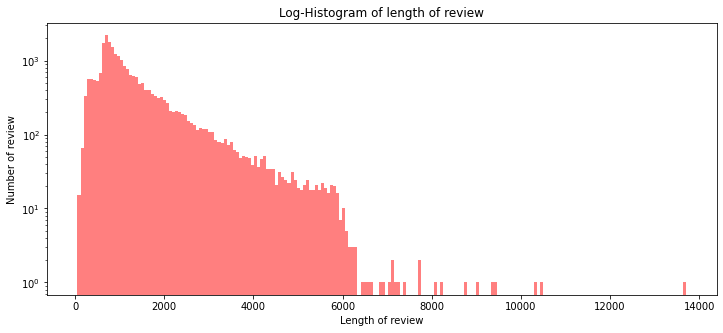

In [ ]:
#review 데이터 형태 확인을 위해 히스토그램 그리기
plt.figure(figsize = (12,5))
plt.hist(train_length, bins = 200, alpha = 0.5, color = 'r', label = 'word')
plt.yscale('log', nonposy = 'clip') #nonposy = 유효하지 않은 값을 아주 작은 값으로 잘라냄
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [ ]:
#review 데이터 형태 확인을 위한 통계값 출력
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_data)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간값: {}'.format(np.median(train_length)))
print('리뷰 길이 제1사분위: {}'.format(np.percentile(train_length,25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(train_length,75)))

리뷰 길이 최댓값: 13710
리뷰 길이 최솟값: id                                                       "0_3"
sentiment                                                    0
review       "A Turkish Bath sequence in a film noir lo...
dtype: object
리뷰 길이 평균값: 1329.71
리뷰 길이 표준편차: 1005.22
리뷰 길이 중간값: 983.0
리뷰 길이 제1사분위: 705.0
리뷰 길이 제3사분위: 1619.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f55b1a1b150>,
 'caps': [<matplotlib.lines.Line2D at 0x7f55b18a4510>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f55b18a0a90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f55b18a4b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f55b1871950>],
 'means': [<matplotlib.lines.Line2D at 0x7f55b24666d0>]}

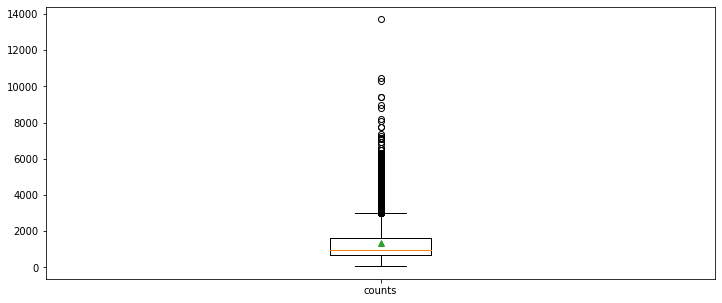

In [ ]:
#review 데이터 형태 확인을 위한 박스플롯 출력
plt.figure(figsize=(12,5))
plt.boxplot(train_length,
            labels = ['counts'],
            showmeans=True) #showmeans: 평균값 마크 유무

(-0.5, 799.5, 599.5, -0.5)

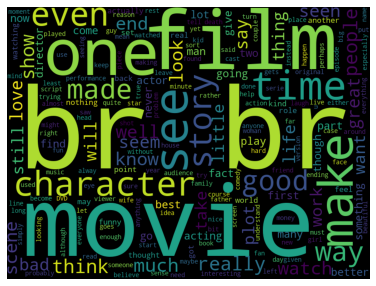

In [ ]:
#review 데이터 형태 확인을 위한 워드클라우드 출력
from wordcloud import WordCloud
cloud = WordCloud(width = 800, height = 600).generate(" ".join(train_data['review'])) #문자열로 인자 전달을 위해 공백 삽입 후 join
plt.figure(figsize=(12,5))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
#단어 개수 확인
train_word_counts = train_data['review'].apply(lambda x:len(x.split(' ')))
train_word_counts

0        433
1        158
2        378
3        379
4        367
        ... 
24995     95
24996    174
24997    127
24998    197
24999    184
Name: review, Length: 25000, dtype: int64

In [ ]:
#구두점 및 대소문자 비율 값 확인
qmarks = np.mean(train_data['review'].apply(lambda x: '?' in x))
fullstop = np.mean(train_data['review'].apply(lambda x: '.' in x))
capitalizing = np.mean(train_data['review'].apply(lambda x: x[0].isupper()))
capitals = np.mean(train_data['review'].apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_data['review'].apply(lambda x: max([y.isdigit() for y in x])))

print('물음표가 있는 질문: {:.2f}%'.format(qmarks*100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop*100))
print('대문자로 시작하는 질문: {:.2f}%'.format(capitalizing*100))
print('대문자가 있는 질문: {:.2f}%'.format(capitals*100))
print('숫자가 있는 질문: {:.2f}%'.format(numbers*100))

물음표가 있는 질문: 29.55%
마침표가 있는 질문: 99.69%
대문자로 시작하는 질문: 0.00%
대문자가 있는 질문: 99.59%
숫자가 있는 질문: 56.66%


# **□데이터 전처리**

In [ ]:
def preprocessing(review, remove_stopwords = False):
  review_text = BeautifulSoup(review,'html5lib').get_text() #Beautiful Soup 활용해서 HTML 태그 제거
  review_text = re.sub('[^a-zA-Z]', ' ', review_text) #영어를 제외한 특수문자 등 제거
  words = review_text.lower().split() #소문자 변환 및 리스트화
  if remove_stopwords:
    stops = set(stopwords.words('english')) #영어 불용어들 집합으로 가져오기
    words = [w for w in words if w not in stops]
    clean_review = ' '.join(words)
  else:
    clean_review = ' '.join(words)
    
  return clean_review

In [ ]:
clean_train_reviews = []
for review in train_data['review']:
  clean_train_reviews.append(preprocessing(review, remove_stopwords = True))

KeyboardInterrupt: ignored

In [ ]:
#현재까지 전처리한 데이터(텍스트 형태)를 DataFrame으로 저장
clean_train_df = pd.DataFrame({'review': clean_train_reviews, 'sentiment': train_data['sentiment']})
clean_train_df.head()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews) #텍스트 속 단어들을 인덱스 벡터로 변환

In [ ]:
word_vocab = tokenizer.word_index #단어 사전을 통해 무슨 단어가 어떤 인덱스로 저장되었는 지 확인
word_vocab["<PAD>"] = 0 #단어 사전에 패딩 값 추가
print(word_vocab)

In [ ]:
data_configs = {} #데이터에 대한 정보를 사전으로 dict로 저장
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

In [ ]:
#패딩 처리하기
MAX_SEQUENCE_LENGTH = 174 #문장 최대 길이, 데이터 문장 길이의 중간값
train_inputs = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post') #padding = 'post' 뒤를 0으로 패딩(기본값은 앞)
print('Shape of Data: {}'.format(train_inputs.shape))

In [ ]:
train_labels = np.array(train_data['sentiment'])
print('Shape of Label Tensor: {}'.format(train_labels.shape))

In [ ]:
#데이터 저장하기
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
clean_train_df.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index = False)
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii= False)

In [ ]:
#테스트 데이터 전처리
test_data = pd.read_csv(DATA_IN_PATH + 'testData.tsv', header = 0, delimiter ='\t', quoting = 3)

clean_test_reviews = []
for reviews in test_data['review']:
  clean_test_reviews.append(preprocessing(review, remove_stopwords = True))
clean_test_df = pd.DataFrame({'review':clean_test_reviews, 'id': test_data['id']})
test_id = np.array(test_data['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

In [ ]:
#테스트 데이터 저장하기
TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)

# **□머신러닝 모델**

### **Linear Regression Model**

---

In [ ]:
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])


In [ ]:
#TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.0 , analyzer = 'char', sublinear_tf = True, ngram_range = (1,3), max_features = 5000)
#analyzer: 분석단위 char or word / sublinear_tf: 빈도수 스무딩 여부 / ngram_range: 빈도의 기본단위에 대한 ngram 범위

X = vectorizer.fit_transform(reviews)

In [ ]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 55
TEST_SPLIT = 0.2

y = np.array(sentiments)

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = TEST_SPLIT, random_state = RANDOM_SEED)

In [ ]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight = 'balanced')
lgs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

In [ ]:
print("Accuracy: %f" %lgs.score(X_eval, y_eval))

Accuracy: 0.859600


In [ ]:
testDataVecs = vectorizer.transform(test_data['review']) #평가 데이터는 fit 하지 않고 transform만 호출. fit은 test 데이터에 맞게 설정된 상태

test_predicted = lgs.predict(testDataVecs)
test_predicted

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_OUT_PATH)

ids = list(test_data['id'])
answer_dataset = pd.DataFrame({'id': ids, 'sentiment' : test_predicted})
answer_dataset.to_csv(DATA_OUT_PATH + 'lgs_tfidf_answer.csv', index = False, quoting = 3)